In [1]:
import tensorflow as tf
import numpy as np
from scipy.fft import dctn
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

2024-11-07 13:46:34.897096: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 13:46:35.085667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 13:46:35.085707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 13:46:35.115346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 13:46:35.176222: I tensorflow/core/platform/cpu_feature_guar

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [5]:
N = 5  # Adjust this as needed

# Convert train_labels to a 1D array for easier manipulation
train_labels = train_labels.flatten()

# Initialize a list to hold the selected sets
unique_selections = []

# Iterate N times to generate N unique sets
for _ in range(N):
    selected_set = []
    used_indices = set()
    
    # Sample one image for each label (0 through 9)
    for label in range(10):
        # Find indices of all images with the current label
        label_indices = np.where(train_labels == label)[0]
        
        # Filter out indices that have been used in previous selections
        available_indices = list(set(label_indices) - used_indices)
        
        # Randomly choose one index from the available ones
        chosen_index = np.random.choice(available_indices)
        
        # Add the chosen index and image to the selection
        selected_set.append((train_images[chosen_index], train_labels[chosen_index]))
        
        # Mark the index as used
        used_indices.add(chosen_index)
    
    # Add the set of 10 images (one per label) to the unique selections list
    unique_selections.append(selected_set)

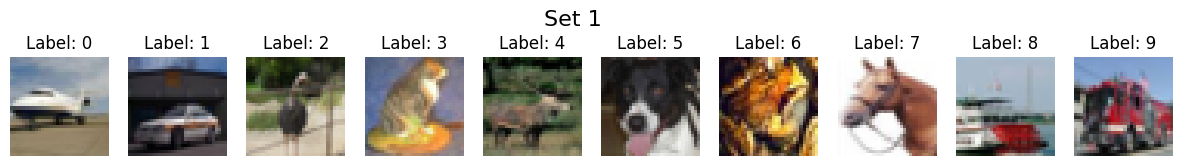

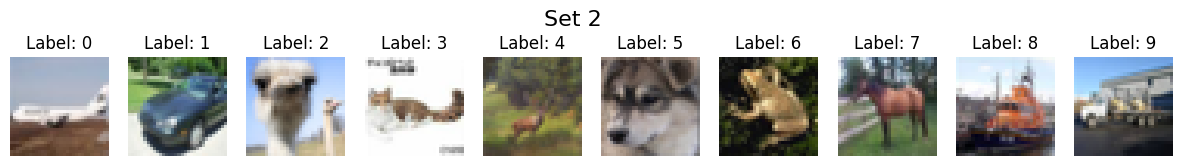

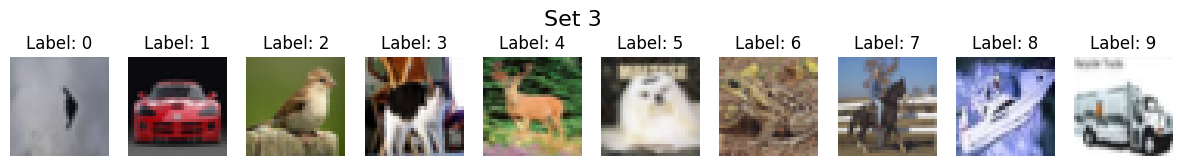

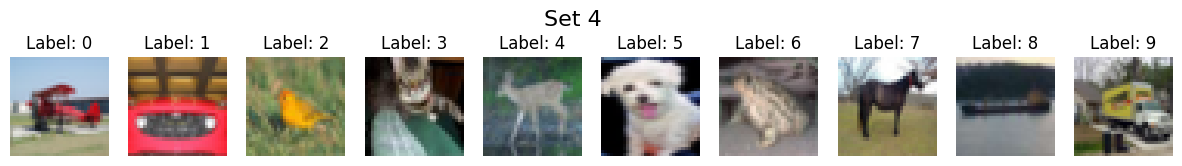

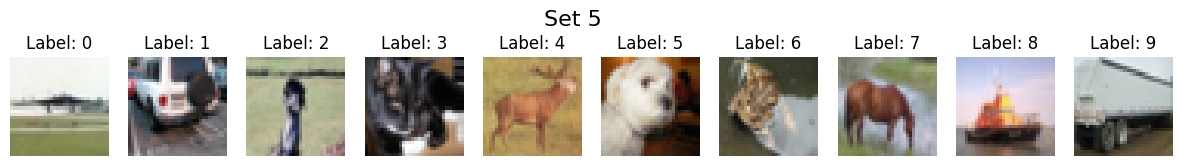

In [9]:
import matplotlib.pyplot as plt

# Function to visualize a set of images (one for each label)
def visualize_set(selected_set, set_index):
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    fig.suptitle(f"Set {set_index + 1}", fontsize=16)
    for i, (image, label) in enumerate(selected_set):
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")

# Visualize each unique selection set
for i, selected_set in enumerate(unique_selections):
    visualize_set(selected_set, i)
    plt.show()


In [10]:
# Separate train images and labels from each selection set
all_images = []  # List to store images from each set
all_labels = []  # List to store labels from each set

for selected_set in unique_selections:
    images = [item[0] for item in selected_set]  # Extract images
    labels = [item[1] for item in selected_set]  # Extract labels
    all_images.append(images)
    all_labels.append(labels)

# Now, all_images[i] and all_labels[i] contain the images and labels of the i-th unique set.


In [12]:
all_labels[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [14]:
model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(128, activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

2024-11-07 13:56:45.226443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-07 13:56:45.328783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-07 13:56:45.328930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [15]:
model_copies = [tf.keras.models.clone_model(model) for _ in range(N)]

In [17]:
for i in range(N):
    model_copies[i].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model_copies[i].fit(np.array(all_images[i]), np.array(all_labels[i]), epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


2024-11-07 14:00:15.491426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-07 14:00:15.681353: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-11-07 14:00:16.687520: I external/local_xla/xla/service/service.cc:168] XLA service 0x7559781a28c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-07 14:00:16.687538: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-07 14:00:16.694922: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730955616.754451   74769 device_compiler.h:186] Compiled cluster using XL

1/1 [==============================] - 4s 4s/step - loss: 3.5800 - accuracy: 0.0000e+00 - val_loss: 3.5046 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 20ms/step - loss: 3.1755 - accuracy: 0.0000e+00 - val_loss: 3.0651 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 19ms/step - loss: 3.6443 - accuracy: 0.1250 - val_loss: 3.1494 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 20ms/step - loss: 2.3197 - accuracy: 0.2500 - val_loss: 3.2548 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 21ms/step - loss: 2.7383 - accuracy: 0.1250 - val_loss: 3.0739 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 20ms/step - loss: 2.1803 - accuracy: 0.2500 - val_loss: 3.0107 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 20ms/step - loss: 1.9854 - accuracy: 0.1250 - val_loss: 3.0119 - val_accuracy: 0.0000e+00
Epoc

In [18]:
def properties(model, layer_name, property_name):
    filter_norms = []
    filter_correlation = []
    feature_map_correlation = []
    feature_map_dct = []

    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    num_filters = filters.shape[-1]

    if property_name == 'filter_norm':
        for i in range(num_filters):
            filt = filters[:, :, :, i]
            filt_matrix = filt.reshape(-1, filt.shape[-1])
            norm = np.linalg.norm(filt_matrix)
            filter_norms.append(norm)
        return filter_norms
    
    elif property_name == 'filter_correlation':
        for i in range(num_filters):
            filt = filters[:, :, :, i]
            filt_matrix = filt.reshape(-1, filt.shape[-1])
            uniqueness = np.linalg.norm(filt_matrix) - np.linalg.norm(get_all_filters(model, layer_name))
            filter_correlation.append(uniqueness)
        return filter_correlation
    
    elif property_name == 'feature_map_correlation':
        intermediate_model = models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_maps = intermediate_model.predict(train_images[:1000])
        for i in range(num_filters):
            U, S, Vt = np.linalg.svd(feature_maps[:,:,:,i])
            #feature_map_correlation.append(np.sqrt(np.sum(np.abs(feature_maps))) - np.sqrt(np.sum(np.abs(feature_maps[:,:,:,i]))) )
            feature_map_correlation.append(np.sum(S > 1e-5))
        return feature_map_correlation
    
    elif property_name == 'feature_map_dct':
        intermediate_model = models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_maps = intermediate_model.predict(train_images[:1000])
        for i in range(num_filters):
            feature_map_dct.append(np.sqrt(np.sum(np.abs(dctn(feature_maps, norm='ortho')))) - np.sqrt(np.sum(np.abs(dctn(feature_maps[:,:,:,i], norm='ortho')))) )
        return feature_map_dct

In [19]:
def filter_to_keep(norms, percentage):
    threshold = np.percentile(norms, percentage)
    return [i for i, norm in enumerate(norms) if norm >= threshold]

In [23]:
def keep_filter_in_model(model):
    keep_filters ={}
    for layer in model.layers:
        if 'conv' in layer.name and layer.name != 'conv1' and layer.name != 'conv2':
            norms = properties(model, layer.name, 'feature_map_dct')
            keep_filters[layer.name] = filter_to_keep(norms, 95)
    return keep_filters

In [24]:
keep_filter_in_model(model_copies[0])

32/32 [==============================] - 0s 916us/step


{'conv3': [20, 22, 29, 40],
 'conv4': [11, 30, 45, 58],
 'conv5': [10, 24, 33, 53, 75, 91, 116],
 'conv6': [0, 28, 32, 65, 83, 90, 122],
 'conv7': [4, 11, 64, 77, 78, 79, 106, 131, 140, 186, 189, 193, 241]}

In [25]:
def dict_keep_filters_in_model(model_list):
    dict_keep_filters = {}
    for i, model in enumerate(model_list):
        dict_keep_filters[i] = keep_filter_in_model(model)
    return dict_keep_filters

In [27]:
model_dict = dict_keep_filters_in_model(model_copies)

32/32 [==============================] - 0s 899us/step


In [28]:
def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name

def copy_weights_pruned(source_model, pruned_target_model, source_layer_names, target_layer_names, keep_filters):
    for source_layer, target_layer in zip(source_model.layers, pruned_target_model.layers):
        if isinstance(source_layer, tf.keras.layers.Conv2D) and source_layer.name not in source_layer_names and target_layer.name not in target_layer_names:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w, b])
        elif source_layer.name in source_layer_names and target_layer.name in target_layer_names:
            for keep_filt in keep_filters:
                if source_layer.name in get_var_name(keep_filt):
                    w, b = source_layer.get_weights()
                    target_layer.set_weights([w[:, :, :, keep_filt], b[keep_filt]])

In [59]:
def change_filters(model, layer_names, new_filter_count):
    new_layers = []
    for layer in model.layers:
        if layer.name in layer_names and isinstance(layer, Conv2D):
            # Get the existing configuration and change the filter count
            config = layer.get_config()
            config['filters'] = new_filter_count
            # Recreate the layer with the new filter count
            new_layer = Conv2D.from_config(config)
            new_layers.append(new_layer)
        else:
            # Keep the original layer if it doesn't match the criteria
            new_layers.append(layer)
    
    # Rebuild the model with the modified layers
    new_model = Sequential(new_layers)
    return new_model

In [60]:
list(model_dict[0].keys())[0]

'conv3'

In [61]:
list(model_dict[0].values())[0]

[20, 22, 29, 40]

In [62]:
def build_pruned_models(model_list, model_dict):
    pruned_models = []
    for i in model_dict:
        pruned_model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(model_dict[i]['conv3']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(model_dict[i]['conv4']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(model_dict[i]['conv5']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(model_dict[i]['conv6']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(model_dict[i]['conv7']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(model_dict[i]['conv7']), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

        copy_weights_pruned(model_list[i], pruned_model, list(model_dict[i].keys()), list(model_dict[i].keys()), model_dict[i].values())
        pruned_models.append(pruned_model)
    return pruned_models
        

In [64]:
pruned_models = build_pruned_models(model_copies, model_dict)

In [65]:
pruned_models[0].summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 dropout_44 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 4)         1156      
                                                                 
 conv4 (Conv2D)              (None, 16, 16, 4)         148       
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 4)         

In [66]:
model_copies[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)          0

In [67]:
# doesnt work yet

def build_pruned_models2(model_list, model_dict):
    pruned_models = []
    for i in model_dict:
        pruned_model = tf.keras.models.clone_model(model_list[i])
        for j in range(len(model_dict[i])):
            change_filters(pruned_model, list(model_dict[i].keys())[j], len(list(model_dict[i].values())[j]))            
        pruned_models.append(pruned_model)
    return pruned_models


In [ ]:
def survived_filters_per_layer(model_dict, model_copies):
    survived_filters = {}
    for i in model_dict[0].keys():
        filters = {}
        for j in model_dict:
            filters[j] = model_copies[j].get_layer(name = i).get_weights()[0]
        survived_filters[i] = filters
    return survived_filters # still has a bug

def survived_filters_per_layer_indexes(model_dict):
    survived_filters = {}
    for i in model_dict[0].keys():
        filters = {}
        for j in model_dict:
           filters[j] = model_dict[j][i]
        survived_filters[i] = filters
    return survived_filters
        

In [ ]:
model_copies[0].get_layer(name = 'conv7').get_weights()[0]

(3, 3, 128, 256)

In [143]:
survived_filters_indexes = survived_filters_per_layer_indexes(model_dict)

In [146]:
survived_filters = survived_filters_per_layer(model_dict, model_copies)

In [152]:
survived_filters_indexes['conv3'].keys()

dict_keys([0, 1, 2, 3, 4])

In [153]:
survived_filters['conv3'].keys()

dict_keys([0, 1, 2, 3, 4])

In [158]:
survived_filters_indexes['conv3'][0].shape

AttributeError: 'list' object has no attribute 'shape'

In [157]:
survived_filters['conv3'][0].shape

(3, 3, 32, 64)